In [3]:
import pandas as pd
import requests as r
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [4]:
api_key = "aBIdeyJp18dnYHxOLyICUOdCfrz7C2g1VFRdCQbx"


In [5]:
solar_monthly_url = f"https://api.eia.gov/v2/electricity/electric-power-operational-data/data/?frequency=monthly&data[0]=generation&facets[fueltypeid][]=SPV&facets[location][]=MO&facets[sectorid][]=99&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"
wind_monthly_url = f"https://api.eia.gov/v2/electricity/electric-power-operational-data/data/?frequency=monthly&data[0]=generation&facets[fueltypeid][]=WND&facets[location][]=MO&facets[sectorid][]=99&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"

In [6]:
try:
    (request := r.get(solar_monthly_url))
    print("Success")
except Exception as e:
    print(e)

Success


In [7]:
json_data = request.json()

In [8]:
solar_generation = pd.DataFrame(json_data.get('response').get('data'))

In [9]:
solar_generation.head()

,period,location,stateDescription,sectorid,sectorDescription,fueltypeid,fuelTypeDescription,generation,generation-units
0,2023-01,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,9.56056,thousand megawatthours
1,2022-12,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,7.20169,thousand megawatthours
2,2022-11,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,9.47591,thousand megawatthours
3,2022-10,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,14.40455,thousand megawatthours
4,2022-09,MO,Missouri,99,All Sectors,SPV,solar photovoltaic,15.42541,thousand megawatthours


In [10]:
solar_generation.period = pd.to_datetime(solar_generation.period)

<AxesSubplot:xlabel='period', ylabel='generation'>

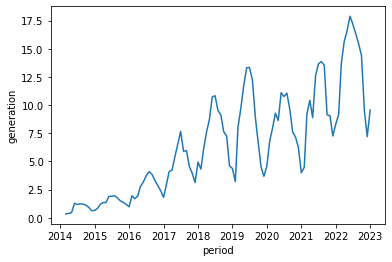

In [11]:
sns.lineplot(x="period",y="generation",data=solar_generation)

In [12]:
index=pd.DatetimeIndex(solar_generation.period).to_period("M")
y = pd.Series(solar_generation.generation.values, index=index)
arima = ARIMA(y,order=(2,0,2)).fit()

c:\users\josh\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
c:\users\josh\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
c:\users\josh\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


In [13]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  107
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -191.038
Date:                Sun, 09 Apr 2023   AIC                            394.076
Time:                        20:12:36   BIC                            410.113
Sample:                             0   HQIC                           400.577
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4249      2.181      2.945      0.003       2.150      10.700
ar.L1          1.3939      0.278      5.023      0.000       0.850       1.938
ar.L2         -0.4780      0.261     -1.829      0.0

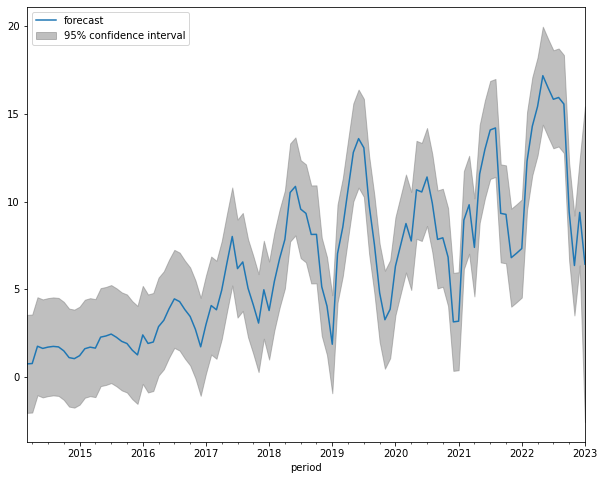

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(arima, ax=ax)
legend = ax.legend(loc="upper left")

In [15]:
sarimax = SARIMAX(y,order=(2,0,2),seasonal_order=(2,0,2,12)).fit()

c:\users\josh\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
c:\users\josh\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


In [16]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  107
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 12)   Log Likelihood                -178.096
Date:                            Sun, 09 Apr 2023   AIC                            374.192
Time:                                    20:12:39   BIC                            398.247
Sample:                                         0   HQIC                           383.944
                                            - 107                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2225      0.472      0.471      0.638      -0.704       1.149
ar.L2          0.6790      0.434      1.563      0.118      -0.172       1.530
ma.L1          0.7592      0.480      1.581      0.114      -0.182       1.700
ma.L2          0.0988      0.112      0.883      0.377      -0.120       0.318
ar.S.L12      -0.0368      4.512     -0.008      0.993      -8.880       8.807
ar.S.L24       0.8332      3.937      0.212      0.832      -6.883       8.549
ma.S.L12       0.4135      4.685      0.088      0.930      -8.769       9.596
ma.S.L24      -0.5066      2.260     -0.224      0.823      -4.936       3.922
sigma2         1.4757      0.270      5.471      0.000       0.947       2.004
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                12.46
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

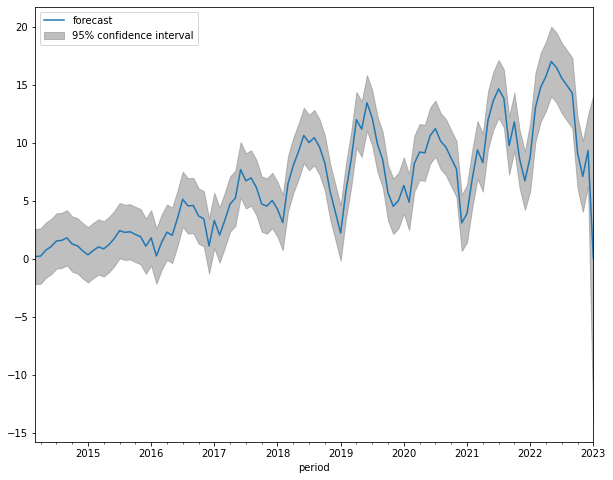

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = plot_predict(sarimax, ax=ax)
legend = ax.legend(loc="upper left")

In [18]:
try:
    (request := r.get(wind_monthly_url))
    print("Success")
except Exception as e:
    print(e)

Success


In [19]:
json_data = request.json()

In [20]:
wind_generation = pd.DataFrame(json_data.get('response').get('data'))

In [21]:
wind_generation.head()

,period,location,stateDescription,sectorid,sectorDescription,fueltypeid,fuelTypeDescription,generation,generation-units
0,2023-01,MO,Missouri,99,All Sectors,WND,wind,664.16199,thousand megawatthours
1,2022-12,MO,Missouri,99,All Sectors,WND,wind,765.94774,thousand megawatthours
2,2022-11,MO,Missouri,99,All Sectors,WND,wind,794.67596,thousand megawatthours
3,2022-10,MO,Missouri,99,All Sectors,WND,wind,568.17608,thousand megawatthours
4,2022-09,MO,Missouri,99,All Sectors,WND,wind,468.58903,thousand megawatthours


In [22]:
wind_generation.period = pd.to_datetime(wind_generation.period)

<AxesSubplot:xlabel='period', ylabel='generation'>

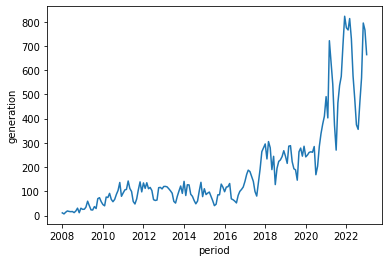

In [23]:
sns.lineplot(x="period",y="generation",data=wind_generation)

Hourly Prediction

In [24]:
solar_hourly_url = f"https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?frequency=hourly&data[0]=value&facets[fueltype][]=SUN&facets[respondent][]=MISO&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"
wind_hourly_url = f"https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?frequency=hourly&data[0]=value&facets[respondent][]=MISO&facets[fueltype][]=WND&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"

In [25]:
try:
    (request := r.get(solar_hourly_url))
    print("Success")
except Exception as e:
    print(e)

Success


In [26]:
json_data = request.json()

In [27]:
hourly_solar_generation = pd.DataFrame(json_data.get('response').get('data'))

In [28]:
hourly_solar_generation.head()

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2023-04-09T05,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,2,megawatthours
1,2023-04-09T04,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,2,megawatthours
2,2023-04-09T03,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
3,2023-04-09T02,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
4,2023-04-09T01,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,41,megawatthours


In [29]:
hourly_solar_generation.period = pd.to_datetime(hourly_solar_generation.period,utc=True)


In [30]:
hourly_solar_generation.head()

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2023-04-09 05:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,2,megawatthours
1,2023-04-09 04:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,2,megawatthours
2,2023-04-09 03:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
3,2023-04-09 02:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours
4,2023-04-09 01:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,41,megawatthours


<AxesSubplot:xlabel='period', ylabel='value'>

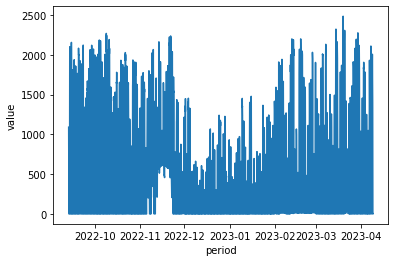

In [31]:
sns.lineplot(x="period",y="value",data=hourly_solar_generation)

In [32]:
try:
    (request := r.get(wind_hourly_url))
    print("Success")
except Exception as e:
    print(e)

Success


In [33]:
json_data = request.json()

In [34]:
hourly_wind_generation = pd.DataFrame(json_data.get('response').get('data'))

In [35]:
hourly_wind_generation.period = pd.to_datetime(hourly_wind_generation.period,utc=True)

In [36]:
hourly_wind_generation.head()

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2023-04-09 05:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,15878,megawatthours
1,2023-04-09 04:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,15399,megawatthours
2,2023-04-09 03:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,16052,megawatthours
3,2023-04-09 02:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,16259,megawatthours
4,2023-04-09 01:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",WND,Wind,14702,megawatthours


<AxesSubplot:xlabel='period', ylabel='value'>

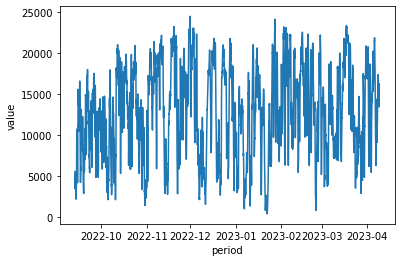

In [37]:
sns.lineplot(x="period",y="value",data=hourly_wind_generation)

Weather Data

In [38]:
weather_hourly_url = "https://api.weather.gov/stations/KSTL/observations?limit=500"

In [39]:
try:
    (request := r.get(weather_hourly_url))
    print("Successful")
except Exception as e:
    print(e)

Successful


In [40]:
json_data = request.json()

In [41]:
d= json.loads(request.text)

In [42]:
parsed = [d["features"][i]["properties"] for i in range(0,len(d["features"]))]

for i in range(0,len(parsed)):
    for key in parsed[i].keys():
        if isinstance(parsed[i][key],dict):
            if "value" in parsed[i][key]:
                parsed[i][key] = parsed[i][key]["value"]

In [43]:
hourly_observation_data = pd.DataFrame(parsed)

In [44]:
hourly_observation_data.shape

(181, 26)

In [45]:
forecast_url = "https://api.weather.gov/gridpoints/LSX/89,80/forecast/hourly"

In [46]:
try:
    (request := r.get(forecast_url))
    print("Successful")
except Exception as e:
    print(e)

Successful


In [47]:
d = json.loads(request.text)

In [48]:
hourly_forecast_data = pd.DataFrame(d["properties"]["periods"])

In [49]:
hourly_forecast_data.head()

,number,name,startTime,endTime,isDaytime,temperature,temperatureUnit,temperatureTrend,probabilityOfPrecipitation,dewpoint,relativeHumidity,windSpeed,windDirection,icon,shortForecast,detailedForecast
0,1,,2023-04-09T20:00:00-05:00,2023-04-09T21:00:00-05:00,False,63,F,None,"{'unitCode': 'wmoUnit:percent', 'value': 0}","{'unitCode': 'wmoUnit:degC', 'value': 1.111111...","{'unitCode': 'wmoUnit:percent', 'value': 34}",8 mph,SE,"https://api.weather.gov/icons/land/night/sct,0...",Partly Cloudy,
1,2,,2023-04-09T21:00:00-05:00,2023-04-09T22:00:00-05:00,False,60,F,None,"{'unitCode': 'wmoUnit:percent', 'value': 0}","{'unitCode': 'wmoUnit:degC', 'value': 1.111111...","{'unitCode': 'wmoUnit:percent', 'value': 37}",8 mph,SE,"https://api.weather.gov/icons/land/night/sct,0...",Partly Cloudy,
2,3,,2023-04-09T22:00:00-05:00,2023-04-09T23:00:00-05:00,False,58,F,None,"{'unitCode': 'wmoUnit:percent', 'value': 0}","{'unitCode': 'wmoUnit:degC', 'value': 1.666666...","{'unitCode': 'wmoUnit:percent', 'value': 43}",7 mph,SE,"https://api.weather.gov/icons/land/night/sct,0...",Partly Cloudy,
3,4,,2023-04-09T23:00:00-05:00,2023-04-10T00:00:00-05:00,False,56,F,None,"{'unitCode': 'wmoUnit:percent', 'value': 0}","{'unitCode': 'wmoUnit:degC', 'value': 1.666666...","{'unitCode': 'wmoUnit:percent', 'value': 47}",7 mph,SE,"https://api.weather.gov/icons/land/night/few,0...",Mostly Clear,
4,5,,2023-04-10T00:00:00-05:00,2023-04-10T01:00:00-05:00,False,53,F,None,"{'unitCode': 'wmoUnit:percent', 'value': 0}","{'unitCode': 'wmoUnit:degC', 'value': 1.666666...","{'unitCode': 'wmoUnit:percent', 'value': 49}",8 mph,SE,"https://api.weather.gov/icons/land/night/few,0...",Mostly Clear,


In [50]:
hourly_observation_data.head()

,@id,@type,elevation,station,timestamp,rawMessage,textDescription,icon,presentWeather,temperature,...,visibility,maxTemperatureLast24Hours,minTemperatureLast24Hours,precipitationLastHour,precipitationLast3Hours,precipitationLast6Hours,relativeHumidity,windChill,heatIndex,cloudLayers
0,https://api.weather.gov/stations/KSTL/observat...,wx:ObservationStation,172,https://api.weather.gov/stations/KSTL,2023-04-10T00:51:00+00:00,KSTL 100051Z 11007KT 10SM BKN250 16/00 A3030 R...,Mostly Cloudy,https://api.weather.gov/icons/land/night/bkn?s...,[],16.1,...,16090,None,None,NaN,NaN,NaN,33.453418,NaN,NaN,"[{'base': {'unitCode': 'wmoUnit:m', 'value': 7..."
1,https://api.weather.gov/stations/KSTL/observat...,wx:ObservationStation,172,https://api.weather.gov/stations/KSTL,2023-04-09T23:51:00+00:00,KSTL 092351Z 11010KT 10SM BKN250 19/M01 A3030 ...,Mostly Cloudy,https://api.weather.gov/icons/land/day/bkn?siz...,[],18.9,...,16090,None,None,NaN,NaN,NaN,26.838520,NaN,NaN,"[{'base': {'unitCode': 'wmoUnit:m', 'value': 7..."
2,https://api.weather.gov/stations/KSTL/observat...,wx:ObservationStation,172,https://api.weather.gov/stations/KSTL,2023-04-09T22:51:00+00:00,KSTL 092251Z 11015KT 10SM BKN250 20/M01 A3031 ...,Mostly Cloudy,https://api.weather.gov/icons/land/day/bkn?siz...,[],20.0,...,16090,None,None,NaN,NaN,NaN,24.165749,NaN,NaN,"[{'base': {'unitCode': 'wmoUnit:m', 'value': 7..."
3,https://api.weather.gov/stations/KSTL/observat...,wx:ObservationStation,172,https://api.weather.gov/stations/KSTL,2023-04-09T21:51:00+00:00,KSTL 092151Z 11015KT 10SM BKN250 21/M01 A3031 ...,Mostly Cloudy,https://api.weather.gov/icons/land/day/bkn?siz...,[],21.1,...,16090,None,None,NaN,NaN,NaN,22.581219,NaN,NaN,"[{'base': {'unitCode': 'wmoUnit:m', 'value': 7..."
4,https://api.weather.gov/stations/KSTL/observat...,wx:ObservationStation,172,https://api.weather.gov/stations/KSTL,2023-04-09T20:51:00+00:00,KSTL 092051Z 12014G23KT 10SM BKN250 21/M01 A30...,Mostly Cloudy,https://api.weather.gov/icons/land/day/bkn?siz...,[],21.1,...,16090,None,None,NaN,NaN,NaN,22.581219,NaN,NaN,"[{'base': {'unitCode': 'wmoUnit:m', 'value': 7..."


In [51]:
hourly_observation_data.columns

Index(['@id', '@type', 'elevation', 'station', 'timestamp', 'rawMessage',
       'textDescription', 'icon', 'presentWeather', 'temperature', 'dewpoint',
       'windDirection', 'windSpeed', 'windGust', 'barometricPressure',
       'seaLevelPressure', 'visibility', 'maxTemperatureLast24Hours',
       'minTemperatureLast24Hours', 'precipitationLastHour',
       'precipitationLast3Hours', 'precipitationLast6Hours',
       'relativeHumidity', 'windChill', 'heatIndex', 'cloudLayers'],
      dtype='object')

In [52]:
observation_columns_to_keep = ["timestamp","textDescription","temperature","windSpeed",'windDirection']
hourly_observation_data = hourly_observation_data.loc[:,observation_columns_to_keep]

In [53]:
##Temp will need to be converted to Celsius
forecast_columns_to_keep = ["startTime","isDaytime","temperature","windSpeed","windDirection","shortForecast"]
hourly_forecast_data = hourly_forecast_data.loc[:,forecast_columns_to_keep]

In [54]:
hourly_observation_data.timestamp = pd.to_datetime(hourly_observation_data.timestamp).dt.round("H")

In [55]:
hourly_observation_data.head()

,timestamp,textDescription,temperature,windSpeed,windDirection
0,2023-04-10 01:00:00+00:00,Mostly Cloudy,16.1,12.96,110.0
1,2023-04-10 00:00:00+00:00,Mostly Cloudy,18.9,18.36,110.0
2,2023-04-09 23:00:00+00:00,Mostly Cloudy,20.0,NaN,NaN
3,2023-04-09 22:00:00+00:00,Mostly Cloudy,21.1,NaN,NaN
4,2023-04-09 21:00:00+00:00,Mostly Cloudy,21.1,25.92,120.0


In [56]:
hourly_observation_data.shape

(181, 5)

In [57]:
hourly_forecast_data.startTime = pd.to_datetime(hourly_forecast_data.startTime).dt.round("H")

In [58]:
date = str(datetime.date.today())

hourly_weather_url = f"https://archive-api.open-meteo.com/v1/archive?latitude=38.63&longitude=-90.20&start_date=2022-06-01&end_date={date}&hourly=temperature_2m,cloudcover,windspeed_10m"

In [59]:
try:
    (request := r.get(hourly_weather_url))
    print("Successful")
except Exception as e:
    print(e)

Successful


In [60]:
pd.DataFrame(request.json().get("hourly"))

,time,temperature_2m,cloudcover,windspeed_10m
0,2022-06-01T00:00,28.4,30.0,2.1
1,2022-06-01T01:00,27.2,30.0,1.8
2,2022-06-01T02:00,26.1,31.0,6.0
3,2022-06-01T03:00,25.2,32.0,6.0
4,2022-06-01T04:00,24.4,31.0,6.0
...,...,...,...,...
7507,2023-04-09T19:00,NaN,NaN,NaN
7508,2023-04-09T20:00,NaN,NaN,NaN
7509,2023-04-09T21:00,NaN,NaN,NaN
7510,2023-04-09T22:00,NaN,NaN,NaN


Merge data sets

In [61]:
solar_weather = hourly_solar_generation.merge(hourly_observation_data,left_on="period" ,right_on="timestamp",how="inner")

In [62]:
encoder = LabelBinarizer()
encoded_array = encoder.fit_transform(solar_weather.textDescription)

for i,class_ in enumerate(encoder.classes_):
    solar_weather.loc[:,f"description {class_}"] = encoded_array[:,i]
    
solar_weather.head()

,period,respondent,respondent-name,fueltype,type-name,value,value-units,timestamp,textDescription,temperature,...,description Haze,description Heavy Thunderstorms and Heavy Rain,description Light Rain,description Mostly Clear,description Mostly Clear and Windy,description Mostly Cloudy,description Partly Cloudy,description Thunderstorms,description Thunderstorms and Rain,description Thunderstorms and Rain and Fog/Mist
0,2023-04-09 05:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,2,megawatthours,2023-04-09 05:00:00+00:00,Mostly Clear,10.0,...,0,0,0,1,0,0,0,0,0,0
1,2023-04-09 04:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,2,megawatthours,2023-04-09 04:00:00+00:00,Mostly Clear,10.6,...,0,0,0,1,0,0,0,0,0,0
2,2023-04-09 03:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours,2023-04-09 03:00:00+00:00,Mostly Clear,12.8,...,0,0,0,1,0,0,0,0,0,0
3,2023-04-09 02:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,1,megawatthours,2023-04-09 02:00:00+00:00,Clear,13.3,...,0,0,0,0,0,0,0,0,0,0
4,2023-04-09 01:00:00+00:00,MISO,"Midcontinent Independent System Operator, Inc.",SUN,Solar,41,megawatthours,2023-04-09 01:00:00+00:00,Mostly Clear,15.0,...,0,0,0,1,0,0,0,0,0,0


In [63]:
solar_weather.set_index("period", inplace=True)

In [64]:
columns_to_drop = ["respondent","respondent-name","fueltype","type-name","timestamp","windSpeed","windDirection","value-units","textDescription"]
solar_weather.drop(columns_to_drop,axis=1,inplace=True)


In [65]:
solar_weather.dropna(inplace=True)

In [73]:
scaler = MinMaxScaler()
solar_weather = scaler.fit_transform(solar_weather)

In [75]:
n_future = 1
n_past = 12

train_X = []
train_y = []

for i in range(n_past, len(solar_weather) - n_future + 1):
    train_X.append(solar_weather[i - n_past:i, 0:solar_weather.shape[1]])
    train_y.append(solar_weather[i + n_future - 1:i + n_future, 0])
    


In [78]:
train_X, train_y = np.array(train_X),np.array(train_y)

In [79]:
model=Sequential()
model.add(LSTM(50,input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dense(1))
model.compile(loss="mae",optimizer="adam")

In [81]:
history = model.fit(train_X, train_y, epochs=50, batch_size=3,validation_split=0.1)

Epoch 1/50
44/44 [==============================] - 5s 28ms/step - loss: 0.2265 - val_loss: 0.1708
Epoch 2/50
44/44 [==============================] - 0s 10ms/step - loss: 0.1642 - val_loss: 0.1514
Epoch 3/50
44/44 [==============================] - 0s 9ms/step - loss: 0.1188 - val_loss: 0.1631
Epoch 4/50
44/44 [==============================] - 0s 8ms/step - loss: 0.1031 - val_loss: 0.1091
Epoch 5/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0911 - val_loss: 0.1190
Epoch 6/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0988 - val_loss: 0.1565
Epoch 7/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0782 - val_loss: 0.1154
Epoch 8/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0735 - val_loss: 0.1353
Epoch 9/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0724 - val_loss: 0.1251
Epoch 10/50
44/44 [==============================] - 0s 8ms/step - loss: 0.0734 - val_loss: 0.1199
Epoch 11/50
44/44

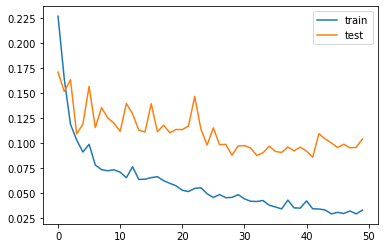

In [82]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [87]:
y_pred_train = model.predict(train_X)

5/5 [==============================] - 0s 6ms/step


In [92]:
pd.concat([pd.Series(train_y[:,0]),pd.Series(y_pred_train[:,0])],axis=1)

,0,1
0,0.909479,0.875631
1,0.854976,0.839688
2,0.800474,0.763874
3,0.553081,0.526879
4,0.005687,0.291257
...,...,...
141,0.000474,-0.005862
142,0.000474,-0.028682
143,0.000474,-0.034225
144,0.000474,0.175983
